# Poor man's implementation of FindAnything
## Mapping - part 1
I'm experimenting with [Open-Vocabulary and Object-Centric Mapping for Robot Exploration in Any Environment](https://arxiv.org/pdf/2504.08603). At least until they release the code, I will try to implement some bits.

In this notebook, I explore the "mapping" portion as shown in the diagram below. Particularly:
1. Over-segmentation of an RGB image via eSAM, and
2. Computing CLIP (dense) features for the segments, and
3. Projecting/fusing into a 3D representation*

*For now, I will use GT pose info for projection into 3D, FindAnything uses VI SLAM with [supereight2](https://github.com/ethz-mrl/supereight2)


![](../images/findanything.png)

First thing is setting up eSAM and CLIP models.
* For eSAM we use the [Efficient Track Anything](https://github.com/yformer/EfficientTAM) version, as I couldn't make the [original eSAM](https://github.com/yformer/EfficientSAM) work.
* For CLIP, I use [my forked version](https://github.com/eduard626/CLIP) of OpenAI's implementation. I added some functionality to be able to extract dense/patch features from the model

eTAM should be a submodule in this repo (see README.md), CLIP could also be a submodule but wil install here locally

In [1]:
import torch
import sys
# CLIP
try:
    import clip
except ImportError:
    raise ImportError("CLIP could not be installed, please check the installation instructions in the README.md file")

# add the submodule path to sys.path
if "eTAM" not in sys.path:
    sys.path.append("eTAM")

try:
    from efficient_track_anything.build_efficienttam import build_efficienttam
except ImportError:
    raise ImportError("Efficient Track Anything could not be installed, please check the installation instructions in the README.md file")


from efficient_track_anything.build_efficienttam import build_efficienttam
from efficient_track_anything.efficienttam_image_predictor import (
    EfficientTAMImagePredictor,
)
from efficient_track_anything.automatic_mask_generator import EfficientTAMAutomaticMaskGenerator

checkpoint = "eTAM/checkpoints/efficienttam_ti_512x512.pt"
model_cfg = "configs/efficienttam/efficienttam_ti_512x512.yaml"

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.allow_tf32 = True

efficienttam = build_efficienttam(model_cfg, checkpoint, device=device)

Image encoder compilation is enabled. First forward pass will be slow.


Final image files: 639 first 5 files: ['1305031542.675341.png', '1305031540.007422.png', '1305031535.175406.png', '1305031542.543425.png', '1305031532.807429.png']


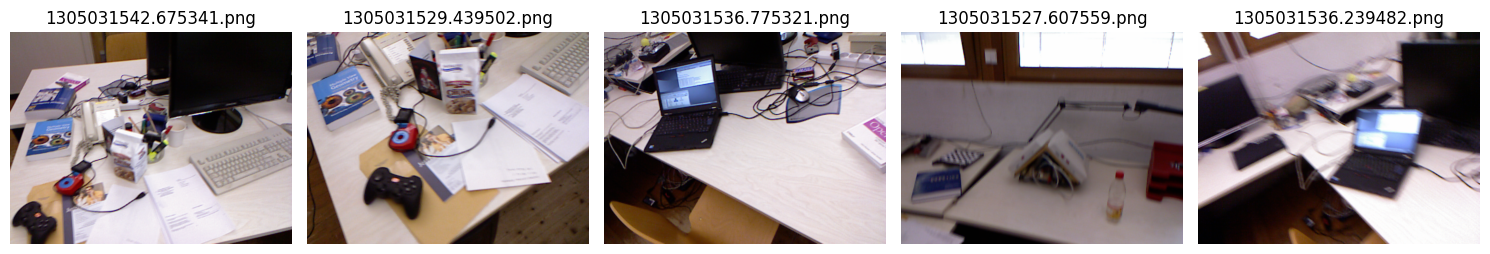

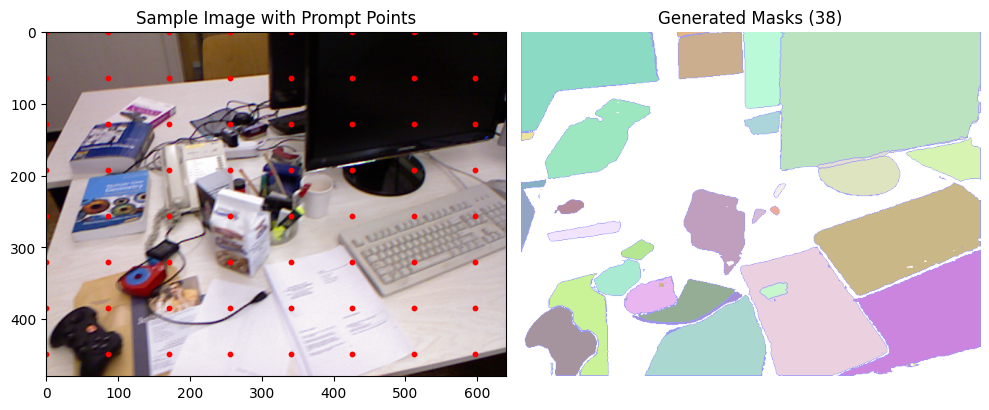

In [2]:
# data from TUM, we will need RGB, DEPTH, CAMERA and STAMP info
# ensure the path to your dataset is correct
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from vlms.utils.data import load_tum_rgb_data
from vlms.utils.visualisation import draw_anns

data_path = "/home/eduardo/Downloads/rgbd_dataset_freiburg1_desk2"
data = load_tum_rgb_data(base_path=data_path, stamp_threshold=0.02, camera_calibration_file=None)
image_files = data["rgb"]
depth_files = data["depth"]
gt_poses = data["poses"]
camera_K = data["camera_intrinsics"]["K"]
camera_P = data["camera_intrinsics"]["P"]

print("Final image files:", len(image_files), "first 5 files:", image_files[:5])

_, ax = plt.subplots(1,5, figsize=(15, 5))
sample_ids = np.linspace(0, len(image_files)-1, 5).astype(int)
for i, image_file_id in enumerate(sample_ids):
    image_file = image_files[image_file_id]
    image_path = os.path.join(data_path, "rgb", image_file)
    assert os.path.exists(image_path), f"Image file {image_path} does not exist"
    image = Image.open(image_path).convert("RGB")
    w, h = image.size
    target_h = 512
    scale = target_h / h 
    w = int(w * scale)
    h = int(h * scale)
    image = image.resize((w, h), Image.Resampling.LANCZOS)
    ax[i].imshow(image)
    ax[i].set_title(f"{image_file}")
    ax[i].axis("off")
plt.tight_layout()
plt.show()

# grid of prompt points: FindAnything uses 8x8 for simulation and 5x5 for real images
grid_side_size = 8
x = [int(i+0.5)*w/grid_side_size for i in range(grid_side_size)]
y = [int(i+0.5)*h/grid_side_size for i in range(grid_side_size)]
input_points = np.meshgrid(x, y)
input_points = np.stack(input_points, axis=-1).reshape(-1, 2)
input_points = input_points / np.array([w, h])  # normalize to [0, 1] range
input_points = input_points.astype(np.float32)


# warmup the model by running on a sample image
sample_image = Image.open(os.path.join(data_path, "rgb", image_files[0])).convert("RGB")
sample_image = np.array(sample_image)

mask_generator = EfficientTAMAutomaticMaskGenerator(
    model=efficienttam,
    points_per_batch=64, # we actually need 25 points (5x5 grid) but this is default
    pred_iou_thresh=0.7,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    point_grids=[input_points, input_points],
    points_per_side=None,
    crop_overlap_ratio=0.25
)

mask = mask_generator.generate(sample_image)
# visualize the masks
drawn_image = draw_anns(mask, borders=True)
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_image)
ax[0].scatter(input_points[:, 0] * w, input_points[:, 1] * h, c='red', s=10)
ax[0].set_title("Sample Image with Prompt Points")
# ax[0].axis("off")
ax[1].imshow(drawn_image)
ax[1].set_title(f"Generated Masks ({len(mask)})")
ax[1].axis("off")
plt.tight_layout()
plt.show()

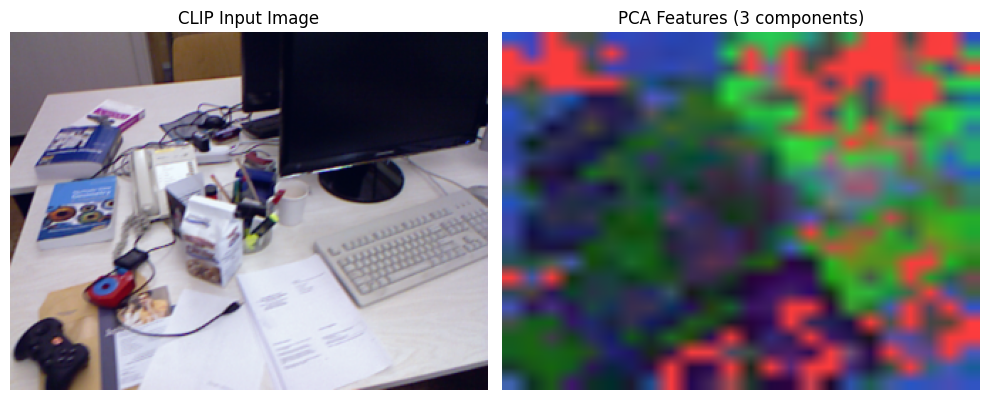

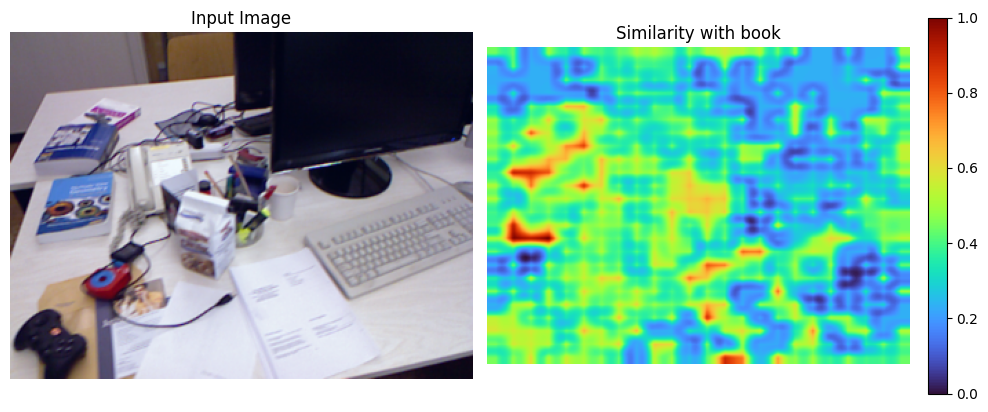

In [3]:
# Following FindAnything, we use CLIP with ViT-L/14@336
from vlms.utils.features import extract_clip_image_features, pca_on_image_features
import torch.nn.functional as F

clip_model, transforms = clip.load("ViT-L/14@336px", device=device, jit=False)
image = Image.open(os.path.join(data_path,"rgb", image_files[0]))
# warp to square size
h, w = image.size
if h != w:
    target_size = min(h, w)
    image = image.resize((target_size, target_size), Image.Resampling.LANCZOS)


input_tensor = transforms(image).unsqueeze(0).to(device)
with torch.no_grad():
    clip_features = clip_model.encode_image(input_tensor, dense_features=True)
image_features = extract_clip_image_features(clip_features, image_size=input_tensor.shape[-2:])
# back to original aspect ratio
original_ratio = w/h
if original_ratio != 1.0:
    # we need to resize the features back to the original aspect ratio
    h, w = image_features.shape[2:4]
    new_h = int(h * original_ratio)
    image_features = torch.nn.functional.interpolate(
        image_features, size=(new_h, w), mode='bilinear', align_corners=False)
    
pca_features = pca_on_image_features(image_features.cpu().numpy(), n_components=3, normalize=True).transpose(1, 2, 0)  # (H, W, n_components)
# resize the input tensor to the original size for visualization
if original_ratio != 1.0:
    h, w = input_tensor.shape[2:4]
    new_h = int(h * original_ratio)
    input_tensor = torch.nn.functional.interpolate(
        input_tensor, size=(new_h, w), mode='bilinear', align_corners=False)
input_image_array = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
input_image_array = 255*(input_image_array - input_image_array.min()) / (input_image_array.max() - input_image_array.min())
pca_features = (pca_features * 255).astype(np.uint8)  # convert to uint8 for visualization

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image_array.astype(np.uint8))
ax[0].set_title("CLIP Input Image")
ax[0].axis("off")
ax[1].imshow(pca_features)
ax[1].set_title("PCA Features (3 components)")
ax[1].axis("off")
plt.tight_layout()
plt.show()

# lets test encoding some text and computing the similarity with the visual features
text_prompts = ["book"]

with torch.no_grad():
    text_features = clip_model.encode_text(clip.tokenize(text_prompts).to(device)) # (1, 768)
text_features = F.normalize(text_features, dim=-1)  # normalize text features
image_features = F.normalize(image_features, dim=1)  # normalize image features along the channel dimension
assert text_features.shape[1] == image_features.shape[1], \
    f"Text features shape {text_features.shape} does not match image features shape {image_features.shape}"

# compute the similarity map
sim_map = -torch.einsum("bchw,bc->bhw", image_features, text_features)  # (H, W)
similarity = sim_map.squeeze(0).cpu().numpy()  # (H, W), remove batch dimension
similarity = (similarity - similarity.min()) / (similarity.max() - similarity.min())  # normalize to [0, 1]

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image_array.astype(np.uint8))
ax[0].set_title("Input Image")
ax[0].axis("off")
bar = ax[1].imshow(similarity, cmap='turbo', vmin=0, vmax=1)
ax[1].set_title(f"Similarity with {text_prompts[0]}")
plt.colorbar(bar, ax=ax[1], fraction=0.046, pad=0.04, shrink=0.8)
ax[1].axis("off")
plt.tight_layout()
plt.show()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Processing depth images:   3%|▎         | 21/639 [00:02<01:11,  8.59it/s]


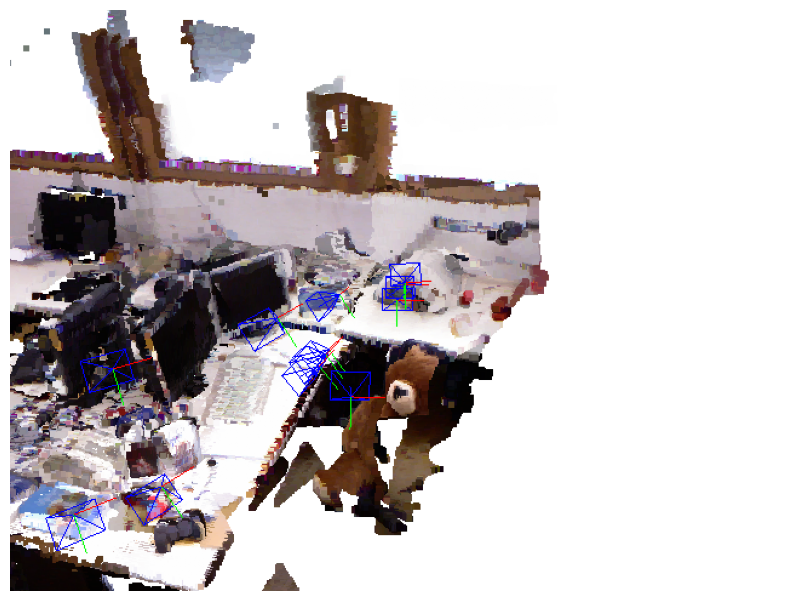

In [4]:
import open3d as o3d

from tqdm import tqdm
import cv2

from vlms.utils.pointcloud import create_posed_cloud

# We will:
# 1. Load depth and RGB images
# 2. Convert depth images to point clouds
# 3. Transform point clouds using ground truth poses
# 4. Visualize the point clouds in Open3D
origin_axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])

viewer = o3d.visualization.Visualizer()
viewer.create_window(width=640,height=480, visible=False)
viewer.add_geometry(origin_axes)

# global pointcloud
big_cloud = o3d.geometry.PointCloud()

max_views = 20

for i, depth_image_file in enumerate(tqdm(depth_files, total=len(depth_files), desc="Processing depth images")):
    if i>max_views:
        break
    # extract timestamp from the filename, assuming format is like "depth_000000.png"
    timestamp = depth_image_file.split('.png')[0]
    
    depth_image_path = os.path.join(data_path, "depth", depth_image_file)
    rgb_image_file = image_files[i]  # we can do this because we matched the files earlier
    depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED) / 5000.0  # Convert to meters
    color_image_path = os.path.join(data_path,"rgb", rgb_image_file)
    color_image = np.array(Image.open(color_image_path).convert("RGB"))
    if color_image.shape[:2] != depth_image.shape[:2]:
        # Resize color image to match depth image size
        color_image = cv2.resize(color_image, (depth_image.shape[1], depth_image.shape[0]), interpolation=cv2.INTER_LINEAR)

    cam_pose = np.eye(4, dtype=np.float64)  # identity matrix, we will apply the transformation later
    cam_pose[:3, :3] = gt_poses["R"][i]  # rotation part
    cam_pose[:3, 3] = gt_poses["T"][i]
    pcd, cam_axis = create_posed_cloud(
        depth_image.astype(np.float32),
        color_image,
        camera_P[:3, :3],
        camera_pose=cam_pose,
        clip_features=None,  # we can pass clip features here if needed
        with_visualization=True        
    )
    
    
    # voxelize to improve visualization performance
    voxel_size = 0.01  # 1 cm voxel size
    pcd = pcd.voxel_down_sample(voxel_size)

    big_cloud += pcd  # accumulate point clouds

    # visualize the camera pose
    viewer.add_geometry(cam_axis)
    # visualize the point cloud
    viewer.add_geometry(pcd)
    # update the viewer
    viewer.poll_events()
    viewer.update_renderer()


# for the viewer camera
# reuse the last camera pose from above, just move back a bit
cam_params = o3d.camera.PinholeCameraParameters()
cam_params.intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width=depth_image.shape[1],
        height=depth_image.shape[0],
        fx=camera_P[0, 0], fy=camera_P[1, 1],
        cx=camera_P[0, 2], cy=camera_P[1, 2])
T_back = np.eye(4, dtype=np.float64)  # local translation along the z-axis, i.e., move the camera a bit back
T_back[:3, 3] = np.array([0, 0, -2.5])  # move back 2.5 meters
cam_pose = cam_pose @ T_back
cam_params.extrinsic = np.linalg.inv(cam_pose)  # world to camera transformation
viewer.get_view_control().convert_from_pinhole_camera_parameters(cam_params, allow_arbitrary=True)
# set the camera position and orientation
viewer.update_renderer()    


# take a screenshot
screenshot = viewer.capture_screen_float_buffer(do_render=True)
screenshot = np.asarray(screenshot)

plt.figure(figsize=(10, 10))
plt.imshow(screenshot)
plt.axis('off')
plt.show()


viewer.destroy_window()

In [ ]:
from vlms.utils.pointcloud import depth_to_point_cloud
# For demo purpose, I'll use a uniform voxel grid to fuse/merge pc features
# i.e, the global representation of the scene
# This would be where we use supereight or other mapping tools
voxel_size = [0.03, 0.03, 0.03]  # 3 cm voxel size
cloud_dims = np.array(big_cloud.get_max_bound()) - np.array(big_cloud.get_min_bound())
num_voxels = np.ceil(cloud_dims / voxel_size).astype(int)
print("Number of voxels:", num_voxels)
# create a voxel grid
x_coords = np.linspace(big_cloud.get_min_bound()[0], big_cloud.get_max_bound()[0], num_voxels[0])
y_coords = np.linspace(big_cloud.get_min_bound()[1], big_cloud.get_max_bound()[1], num_voxels[1])
z_coords = np.linspace(big_cloud.get_min_bound()[2], big_cloud.get_max_bound()[2], num_voxels[2])
# 3d meshgrid to get the voxel centers
voxel_centers = np.array(np.meshgrid(x_coords, y_coords, z_coords, indexing='ij')).reshape(3, -1).T  # (N, 3)

# we need an dict of voxel_id -> avg CLIP feature
# but we wont start the dictionary yet, until we have some 3D points to associate with the voxels

# CLIP features will have a lower resolution than the RGB/depth/segmentation images
# So either we:
# 1. Downsample RGB to match CLIP features resolution 
# 2. Upsample CLIP features to match RGB resolution

# CLIP dense features are already upsample from patch features to the image resolution
# So we try option 1 to avoid additional interpolation on the CLIP features

voxel_centers_pcd = o3d.geometry.PointCloud()
voxel_centers_pcd.points = o3d.utility.Vector3dVector(voxel_centers)
# visualize the voxel centers
kd_tree = o3d.geometry.KDTreeFlann(voxel_centers_pcd)
clip_world_features = {}  # voxel_id -> avg CLIP features
for i in tqdm(range(20)):
    rgb_image_file = image_files[i]
    depth_image_file = depth_files[i]
    depth_image_path = os.path.join(data_path, "depth", depth_image_file)
    rgb_image_path = os.path.join(data_path,"rgb", rgb_image_file)
    depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED) / 5000.0  # Convert to meters
    rgb_image = np.array(Image.open(rgb_image_path).convert("RGB"))
    if rgb_image.shape[:2] != depth_image.shape[:2]:
        # Resize RGB image to match depth image size
        rgb_image = cv2.resize(rgb_image, (depth_image.shape[1], depth_image.shape[0]), interpolation=cv2.INTER_LINEAR)

    # run the mask generator on the RGB image
    masks = mask_generator.generate(rgb_image)
    # extract CLIP features for the RGB image
    # warp the RGB image to square size for CLIP
    h, w = rgb_image.shape[:2]
    if h != w:
        target_size = min(h, w)
        rgb_image_clip = cv2.resize(rgb_image, (target_size, target_size), interpolation=cv2.INTER_LINEAR)
    
    input_tensor = transforms(Image.fromarray(rgb_image_clip)).unsqueeze(0).to(device)
    with torch.no_grad():
        clip_features = clip_model.encode_image(input_tensor, dense_features=True)
    dense_features = extract_clip_image_features(clip_features, input_tensor.shape[-2:])  # (B, C, H, W)
    # warp back to original aspect ratio
    original_ratio = w/h
    if original_ratio != 1.0:
        h, w = dense_features.shape[2:4]
        new_h = int(h * original_ratio)
        dense_features = torch.nn.functional.interpolate(
            dense_features, size=(new_h, w), mode='bilinear', align_corners=False)
        # normalize the features after interpolation
        dense_features /= dense_features.norm(dim=1, keepdim=True)  # normalize features along the channel dimension

    numpy_clip_features = dense_features.squeeze(0).permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    # scale the features to [0, 1] range
    numpy_clip_features = (numpy_clip_features - numpy_clip_features.min()) / (numpy_clip_features.max() - numpy_clip_features.min())
    # convert the dense features to PCA features
    # filter out regions of the image that are not covered by the masks
    mask = np.zeros(rgb_image.shape[:2], dtype=np.uint8)
    for m in masks:
        segment = m["segmentation"]
        mask[segment] = 1  # mark the region covered by the mask
    # set the depth values to 0 where the mask is not present
    depth_image[mask == 0] = 0.0  # set depth to 0 where mask is not present
    
    # downsample rgb and depth images to match the CLIP features resolution
    h, w = numpy_clip_features.shape[:2]
    scale_x = w/rgb_image.shape[1]
    scale_y = h/rgb_image.shape[0]
    rgb_image = cv2.resize(rgb_image, (w, h), interpolation=cv2.INTER_LINEAR)
    depth_image = cv2.resize(depth_image, (w, h), interpolation=cv2.INTER_NEAREST)
    
    # scale the intrinsic matrix P to match the new image size
    P_scaled = camera_P.copy()
    P_scaled[0, 0] *= scale_x  # fx
    P_scaled[1, 1] *= scale_y  # fy
    P_scaled[0, 2] *= scale_x  # cx
    P_scaled[1, 2] *= scale_y # cy
    # point cloud [x, y, z, r, g, b, clip_features...]
    pose = np.eye(4, dtype=np.float64)  # identity matrix, we will apply the transformation later
    pose[:3, :3] = gt_poses["R"][i]  # rotation part
    pose[:3, 3] = gt_poses["T"][i]  #
    point_cloud_numpy = depth_to_point_cloud(
        depth_image.astype(np.float32),
        rgb_image,
        P_scaled[:3, :3],
        clip_features=numpy_clip_features)
    
    # assign the point cloud to the voxel centers
    # check if voxel center has prev features, if so, average them
    # Use the kd tree to find the closest voxel center for each point in the point cloud
    for point in point_cloud_numpy:
        point = np.array(point)  # convert to numpy array
        # transform the point to world coordinates
        point_world = np.dot(pose[:3, :3], point[:3]) + pose[:3, 3]  # (x, y, z)
        point[:3] = point_world  # update the point with the world coordinates
        [k, idx, dist] = kd_tree.search_knn_vector_3d(point[:3], 1)  # search for the closest voxel center
        if k > 0 and dist[0] < voxel_size[0]:  # if we found a voxel center
            # update the CLIP features for the voxel center
            if idx[0] in clip_world_features:
                # average the features
                existing_features = clip_world_features[idx[0]]
                new_features = point[6:]
                # average the features
                clip_world_features[idx[0]]["count"] += 1
                clip_world_features[idx[0]]["features"] = (
                    existing_features["features"] * (existing_features["count"] - 1) + new_features) / existing_features["count"]
            else:
                # create a new entry for the voxel center
                clip_world_features[idx[0]] = {
                    "count": 1,
                    "features": point[6:]
                }

# Now we have a dictionary of voxel_id -> avg CLIP features
# and we know the voxel centers in the world coordinates
# We can visualize the voxel centers and their features in Open3D
voxel_centers_features = []
activated_voxels = np.array(list(clip_world_features.keys()))
centers_3d = voxel_centers[activated_voxels]  # (N, 3)
activated_cloud = o3d.geometry.PointCloud()
activated_cloud.points = o3d.utility.Vector3dVector(centers_3d)
# color based on counts 
counts = np.array([clip_world_features[i]["count"] for i in activated_voxels])
# normalize counts to [0, 1]
counts = (counts - counts.min()) / (counts.max() - counts.min())
# use counts to color the points, e.g., using a colormap
import matplotlib.cm as cm
colors = cm.viridis(counts)[:, :3]  # use viridis colormap and take RGB channels
activated_cloud.colors = o3d.utility.Vector3dVector(colors)


# first pose
T = np.eye(4, dtype=np.float64)
T[:3, :3] = gt_poses["R"][0]  # rotation matrix
T[:3, 3] = gt_poses["T"][0]
extrinsic_matrix = np.linalg.inv(T)
cam_axis = o3d.geometry.LineSet.create_camera_visualization(
    intrinsic=o3d.camera.PinholeCameraIntrinsic(
        width=depth_image.shape[1],
        height=depth_image.shape[0],
        fx=P_scaled[0, 0], fy=P_scaled[1, 1],
        cx=P_scaled[0, 2], cy=P_scaled[1, 2]
    ),
    extrinsic=extrinsic_matrix,
    scale=0.1
)

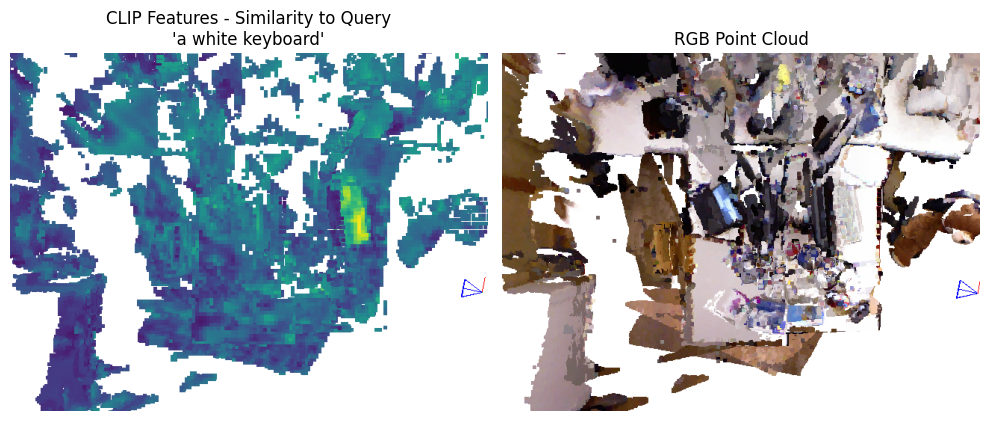

In [25]:
# lets' try query the voxel centers with CLIP features
# first we aggregate the features for faster dot product computation
# we will use a simple average of the features for each voxel center
voxel_features = np.array([clip_world_features[i]["features"] for i in activated_voxels])

text_query = "a white keyboard"  # example text query
# we need to extract CLIP text features for the query
text_tokens = clip.tokenize([text_query]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
text_features = F.normalize(text_features, dim=-1).cpu().numpy()  # normalize text features

# use cosine similarity to find the closest voxel centers
from sklearn.metrics.pairwise import cosine_similarity
similarity_scores = -cosine_similarity(voxel_features, text_features).flatten()  # (N,)
# normalize the scores to [0, 1]
similarity_scores = (similarity_scores - similarity_scores.min()) / (similarity_scores.max() - similarity_scores.min())
# color coded by similarity scores
similarity_colors = cm.viridis(similarity_scores)[:, :3]
activated_cloud.colors = o3d.utility.Vector3dVector(similarity_colors)

# visualize the similarity cloud
viewer = o3d.visualization.Visualizer()
viewer.create_window(width=640, height=480, visible=False)
viewer.add_geometry(activated_cloud)
viewer.add_geometry(origin_axes)
viewer.add_geometry(cam_axis)
viewer.poll_events()
viewer.update_renderer()

viewer.get_view_control().set_zoom(0.3)  # set zoom level

# take a screenshot
screenshot = viewer.capture_screen_float_buffer(do_render=True)
screenshot_sim = np.asarray(screenshot)

# clear and add the RGB point cloud for visualization
viewer.clear_geometries()
viewer.add_geometry(big_cloud)
viewer.add_geometry(origin_axes)
viewer.add_geometry(cam_axis)
# update the viewer
viewer.poll_events()
viewer.update_renderer()
viewer.get_view_control().set_zoom(0.3)  # set zoom level
# take a screenshot
screenshot = viewer.capture_screen_float_buffer(do_render=True)
screenshot = np.asarray(screenshot)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(screenshot_sim)
ax[0].set_title(f"CLIP Features - Similarity to Query\n'{text_query}'")
ax[0].axis("off")
ax[1].imshow(screenshot)
ax[1].set_title(f"RGB Point Cloud")
ax[1].axis("off")
plt.tight_layout()
plt.show()